In [1]:
import math

import equinox as eqx
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import optax  # https://github.com/deepmind/optax
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [155]:
def dataloader(arrays, batch_size):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size
            
            
            
def get_data(dataset_size, *, key):
    x = jnp.expand_dims(jnp.linspace(0, 20 * math.pi, dataset_size),axis=1)
    
    func_value = jnp.sin(x)
    
    
    std_error = 0.5
    
    func_value_with_noise = func_value + jrandom.normal(key, (dataset_size,1))*std_error
    
    input_data = jnp.concatenate([x,func_value_with_noise],axis=1)
    
    output_data = func_value_with_noise < func_value

    return input_data, output_data


In [156]:
xs,ys = get_data(100, key=jax.random.PRNGKey(0))

In [158]:
xs.shape

(100, 2)

In [184]:
from jaxtyping import Float, Array
class MLP(eqx.Module):
    layers: list

    def __init__(self, in_size, out_size, width_size, depth, key):
        keys = jax.random.split(key, depth + 1)
        self.layers = []
        # hidden layers
        for i in range(depth):
            self.layers.append(
                eqx.nn.Linear(
                    in_size if i == 0 else width_size,
                    width_size,
                    key=keys[i]
                )
            )
        # output layer
        self.layers.append(eqx.nn.Linear(width_size, out_size, key=keys[-1]))

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return jax.nn.sigmoid(self.layers[-1](x))

In [198]:
def main(
    dataset_size=10000,
    batch_size=32,
    learning_rate=3e-3,
    steps=200,
    width_size=64,
    depth=3,
    seed=5678,
):
    data_key, model_key = jrandom.split(jrandom.PRNGKey(seed), 2)
    xs, ys = get_data(dataset_size, key=data_key)
    iter_data = dataloader((xs, ys), batch_size)

    model = MLP(in_size=2, out_size=1, width_size=width_size, depth=depth, key=model_key)

    @eqx.filter_value_and_grad
    def compute_loss(model, x, y):
        pred_y = jax.vmap(model)(x)
        # Trains with respect to binary cross-entropy
        return -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))

    # Important for efficiency whenever you use JAX: wrap everything into a single JIT
    # region.
    # @eqx.filter_jit
    def make_step(model, x, y, opt_state):
        print("x.shape",x.shape)
        print("y.shape",y.shape)
        loss, grads = compute_loss(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    optim = optax.adam(learning_rate)
    opt_state = optim.init(model)
    losses = []
    for step, (x, y) in zip(range(steps), iter_data):
        print("x.shape",x.shape)
        print("y.shape",y.shape)
        loss, model, opt_state = make_step(model, x, y, opt_state)
        loss = loss.item()
        print(f"step={step}, loss={loss}")
        losses.append(loss)

    pred_ys = jax.vmap(model)(xs)
    num_correct = jnp.sum((pred_ys > 0.5) == ys)
    final_accuracy = (num_correct / dataset_size).item()
    print(f"final_accuracy={final_accuracy}")
    return model, xs, ys, pred_ys, losses

In [205]:
model,xs,ys,pred_ys,losses = main(dataset_size=10000,learning_rate=1e-3,steps=1000)

x.shape (32, 2)
y.shape (32, 1)
x.shape (32, 2)
y.shape (32, 1)
step=0, loss=0.7853564620018005
x.shape (32, 2)
y.shape (32, 1)
x.shape (32, 2)
y.shape (32, 1)
step=1, loss=0.7075644731521606
x.shape (32, 2)
y.shape (32, 1)
x.shape (32, 2)
y.shape (32, 1)
step=2, loss=0.7969295978546143
x.shape (32, 2)
y.shape (32, 1)
x.shape (32, 2)
y.shape (32, 1)
step=3, loss=0.7550162076950073
x.shape (32, 2)
y.shape (32, 1)
x.shape (32, 2)
y.shape (32, 1)
step=4, loss=0.6483089327812195
x.shape (32, 2)
y.shape (32, 1)
x.shape (32, 2)
y.shape (32, 1)
step=5, loss=0.8572967648506165
x.shape (32, 2)
y.shape (32, 1)
x.shape (32, 2)
y.shape (32, 1)
step=6, loss=0.724086582660675
x.shape (32, 2)
y.shape (32, 1)
x.shape (32, 2)
y.shape (32, 1)
step=7, loss=0.8903803825378418
x.shape (32, 2)
y.shape (32, 1)
x.shape (32, 2)
y.shape (32, 1)
step=8, loss=0.935375452041626
x.shape (32, 2)
y.shape (32, 1)
x.shape (32, 2)
y.shape (32, 1)
step=9, loss=0.6836956143379211
x.shape (32, 2)
y.shape (32, 1)
x.shape (3

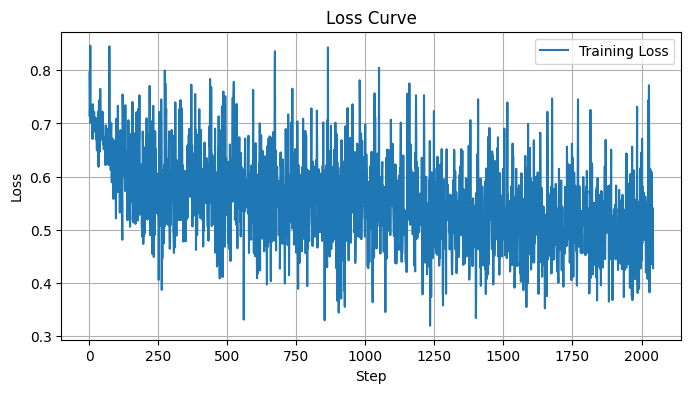

In [204]:
import matplotlib 
import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import optax



import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()
